# VegFrax

## Initialise VegFrax

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import sys
import gdal
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube
sys.path.append('../../../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import vegfrax

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43091 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


## Load lower-res Sentienl data (ODC approach)

### Set study area, time range, show map

In [3]:
# open up a datacube connection
dc = datacube.Datacube(app='vegfrax')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [4]:
# testing study area extent - yandi and roy hill
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

In [5]:
# provide study area name
study_area = 'royhill'

# select start and end year range
time_range = ('2016-01', '2016-12')

# set datacube query parameters
platform = 'landsat'
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
#bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'] # sentinel
min_gooddata = 0.90

# fetch satellite data from dea ard product
ds_raw = satfetcher.load_dea_ard(platform=platform, 
                                 bands=bands, 
                                 x_extent=lon_extent, 
                                 y_extent=lat_extent, 
                                 time_range=time_range, 
                                 min_gooddata=min_gooddata, 
                                 use_dask=True)

# display dataset
#ds_raw

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Loading DEA ODC ARD satellite data.
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)


/home/jovyan/tenement-tools/notebooks/vegfrax/../../../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 16 out of 45 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 16 time steps as a dask array
Satellite imagery fetched successfully.


### Conform band names

In [6]:
# rename dea bands to common standard
ds_raw = satfetcher.conform_dea_ard_band_names(ds=ds_raw, 
                                               platform=platform)

# display dataset
#ds_raw

Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.


### Calculate tasselled cap bands

In [7]:
# calculate veg (mavi) and moist (ndmi) indices
ds_raw = tools.calculate_indices(ds=ds_raw, 
                                 index=['tcg', 'tcb', 'tcw'], 
                                 custom_name=None, 
                                 rescale=False, 
                                 drop=True)

# display dataset
#ds_raw

Calculating indices: ['tcg', 'tcb', 'tcw'].
Calculating index: tcg
Calculating index: tcb
Calculating index: tcw
Calculated indices successfully.


### Reduce to a median of all times

In [8]:
# reduce to median image
ds_raw = ds_raw.median('time', keep_attrs=True)

# set nan to -999
#ds_raw = ds_raw.where(~ds_raw.isnull(), -128)

# compute into memory
ds_raw = ds_raw.compute()

# plot result
#fig = plt.figure(figsize=(6, 6))
#ds_raw['tcg'].plot(robust=True, cmap='terrain_r')

## Load and validate high-res classified local raster

### Load raster

In [9]:
# set path to high-resolution classified image (e.g. 10m Sentinel 2 or 1m WV)
rast_class = r'../../data/vegfrax/class/Vegetation_Mapping_Mine_20181121_rasterised_albers.tif'

# load raster as an xarray dataset and set nodata to -9999
ds_class = satfetcher.load_local_rasters(rast_path_list=[rast_class], 
                                         use_dask=True, 
                                         conform_nodata_to=-128)

# do basic preparations (dtype, rename, checks)
ds_class = vegfrax.prepare_classified_xr(ds=ds_class)

# display result
#ds_class

Converting rasters to an xarray dataset.
Converted raster to xarray data array: Vegetation_Mapping_Mine_20181121_rasterised_albers
Extracting CRS from dataset.
CRS extracted successfully from dataset.
Rasters converted to dataset successfully.

Preparing classified dataset.
Prepared classified dataset successfully.


### Subset extent of classified raster to satellite raster

In [10]:
# subset high to low extent
ds_class = tools.clip_xr_to_xr(ds_a=ds_class, 
                               ds_b=ds_raw)

# display result
#ds_class

Clipping dataset to another.
Extracting spatial extent from dataset.
Clipped dataset successfully.


## Subset classes and mask

### Reclassify dataset into required classes and other

In [11]:
# set desired class values
req_class = [2, 3, 5]

# reclassify all other classes to 0 (and leave nodata as is)
ds_class = vegfrax.reclassify_xr(ds=ds_class, 
                                 req_class=req_class,
                                 nodata_value=-128,
                                 inplace=True)

# display result
#ds_class

Reclassifying classes.
Reclassified dataset successfully.


### Compute into memory

In [12]:
# load into memory now - we have values to modify!
ds_class = ds_class.compute()

# display result
#ds_class

## Prepare random samples

### Generate random samples from raw and classified raster overlaps

In [14]:
# set number of samples per class for training
num_samples = 500

# generate random samples within area overlap between raw and classified rasters
df_samples = vegfrax.generate_strat_random_samples(ds_raw=ds_raw,
                                                   ds_class=ds_class, 
                                                   req_class=req_class,
                                                   num_samples=num_samples)

# display result
#print(df_samples)

Generating 500 stratified randomised sample points.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracting spatial extent from dataset.
Extracting spatial extent from dataset.
Generating stratified random points.
Preparing samples for class: 2


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Preparing samples for class: 3
Preparing samples for class: 5
Generated stratified random sample points successfully.


### Extract values from raw rasters (e.g. low resolution image bands)

In [15]:
# extract pixel values from raw, low resolution rasters at each point
df_extract = tools.extract_xr_values(ds=ds_raw, 
                                     coords=df_samples, 
                                     keep_xy=True, 
                                     nodata_value=-999)

# display result
#print(df_extract)

Extracting xarray dataset values to x and y coordinates.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracted xarray dataset values successfully.


### Remove any no data values from extraction

In [16]:
# remove any points containing a nodata value
df_extract_clean = tools.remove_nodata_records(df_extract, 
                                               nodata_value=-999)

# display result
#print(df_extract_clean)

Removing records containing NoData (-999) values.
Removed 0 records containing NoData values successfully.


## Generate and prepare frequency windows and analysis data

### Build raw focal window extents from random sample points

In [128]:
# generate focal windows and extract pixels from class raster
df_windows = vegfrax.create_frequency_windows(ds_raw=ds_raw, 
                                              ds_class=ds_class, 
                                              df_records=df_extract_clean)

# display result
#print(df_windows)

Creating frequency focal windows from random sample points.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Computing windows into memory, this can take awhile. Please wait.
1500 windows generated successfully.


### Convert raw windows to class frequency information

In [129]:
%autoreload

# transform raw focal window pixel classes and counts to unique classes and frequencies at each point
df_freqs = vegfrax.convert_window_counts_to_freqs(df_windows=df_windows, 
                                                  nodata_value=-128)

# display result
#print(df_freqs)

Generating class frequencies from window pixels.
Checking for empty rows and dropping if exist.
1500 windows transformed to frequencies successfully.


### Select desired analysis classes and prepare data for analysis

In [492]:
# set desired output classes. keep empty to produce all classes. could put 1, 2 for classes 1 and 2.
override_classes = ['3']

# prepare data for analysis - prepare classes, nulls, normalise frequencies
df_data = vegfrax.prepare_freqs_for_analysis(ds_raw, 
                                             ds_class, 
                                             df_freqs, 
                                             override_classes, 
                                             nodata_value=-128)

# display result
#print(df_data)

Converting dataset to sklearn analysis-ready format.
> Converting classes and frequencies into analysis-ready format.
Normalising rows with regards to subset classes and NoData values.
Creating NoData mask.
Data successfully prepared for analysis.


## Perform Fractional Cover Analysis (FCA)

### Perform the FCA 

In [536]:
%autoreload

# perform fca
ds_preds = vegfrax.perform_fca(ds_raw, 
                               ds_class, 
                               df_data, 
                               df_extract_clean, 
                               n_estimators=100,
                               n_validations=10,
                               nodata_value=-128)

Beginning fractional cover analysis (FCA). 
Fitting and predicting model for class: 3
Mean OOB: 0.51. Mean MAE: 0.18. Mean RMSE: 0.3. Mean R-squared: 0.56. Best R-squared: 0.67
Fractional cover analysis (FCA) completed successfully.


## Display a vegetation class

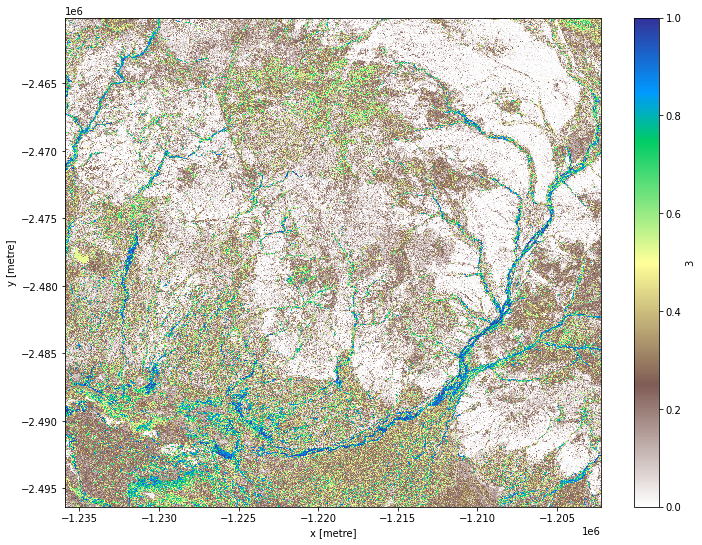

In [537]:
# set the class to plot (e.g. 6 = shrubland, 1 = Eucalyptus woodland)
class_label = '3'

# create fig
fig = plt.figure(figsize=(12, 9))

# plot this class on map
ds_preds[class_label].plot(robust=False, cmap='terrain_r')